✓ Import thư viện thành công
NetworkX version: 3.3


✓ Đã load 1692 nodes và 3932 edges từ korean_artists_graph_bfs.json
✓ Đã load 2778 entities, thêm 2681 nodes mới từ kpop_ner_result.json
✓ Đã load 1898 relationships, thêm 1898 edges mới từ kpop_relationships_result.json

📊 Tổng cộng: 4373 nodes, 5830 edges


✓ Graph có 4373 nodes và 5419 edges

📊 THỐNG KÊ NODES THEO LABEL:
  Song: 1586 (36.3%)
  Artist: 1165 (26.6%)
  Album: 771 (17.6%)
  Company: 323 (7.4%)
  Group: 261 (6.0%)
  Genre: 175 (4.0%)
  Occupation: 60 (1.4%)
  Instrument: 32 (0.7%)


1. PHÂN TÍCH KHÁI NIỆM THẾ GIỚI NHỎ (SMALL WORLD)

📊 Graph có 1869 connected components
   Largest component: 2465 nodes (56.4%)

📊 Largest Component: 2465 nodes, 5377 edges


🔍 Tính Average Shortest Path Length (APL)...

✓ Average Shortest Path Length: 4.3922

🔍 Tính Clustering Coefficient...
✓ Average Clustering Coefficient: 0.0560

🔍 Tính Diameter...
✓ Diameter: 12



🔍 So sánh với Random Graph (Erdős–Rényi)...
------------------------------------------------------------
Average Degree: 4.36

Metric                         Mạng K-pop      Random Graph   
------------------------------------------------------------
Average Path Length            4.3922          5.3018         
Clustering Coefficient         0.0560          0.001770       

📊 Small World Sigma (σ): 38.1944
✓ σ > 1: Mạng có tính chất THẾ GIỚI NHỎ

📋 KẾT LUẬN VỀ KHÁI NIỆM THẾ GIỚI NHỎ:

1. APL = 4.39 ✓ thấp
2. Clustering = 0.0560 ✓ cao hơn random 31x
3. Six Degrees: ✓ APL ≤ 6

🎯 KẾT LUẬN: Mạng K-pop THỎA MÃN tính chất THẾ GIỚI NHỎ (Small World)
   → Bất kỳ 2 nghệ sĩ nào cũng kết nối qua trung bình 4.4 bước


📊 Vẽ biểu đồ phân bố...


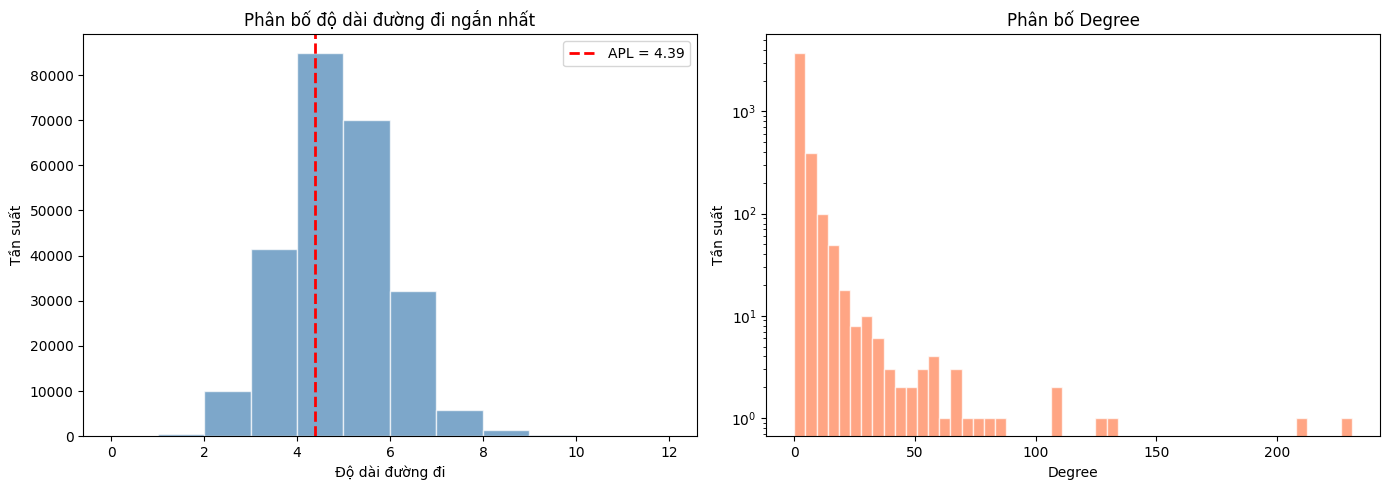

✓ Đã lưu biểu đồ vào small_world_analysis.png


2. XẾP HẠNG NODE BẰNG PAGERANK

🔍 Đang tính PageRank...
✓ Đã tính PageRank cho 4373 nodes

📊 TOP 30 NODES THEO PAGERANK:
----------------------------------------------------------------------


,Rank,Node,Label,PageRank,Degree
0,1,Occupation_Diễn viên,Occupation,0.014255,231
1,2,Genre_R&B,Genre,0.012407,208
2,3,Genre_Dance-pop,Genre,0.007878,131
3,4,Genre_Hip hop,Genre,0.007499,125
4,5,Occupation_Nhạc sĩ,Occupation,0.006380,108
5,6,BTS,Group,0.006266,85
6,7,Genre_Pop,Genre,0.006148,108
7,8,Girls' Generation,Group,0.005675,67
8,9,T-ara,Group,0.004950,60
9,10,EXO,Group,0.004916,70


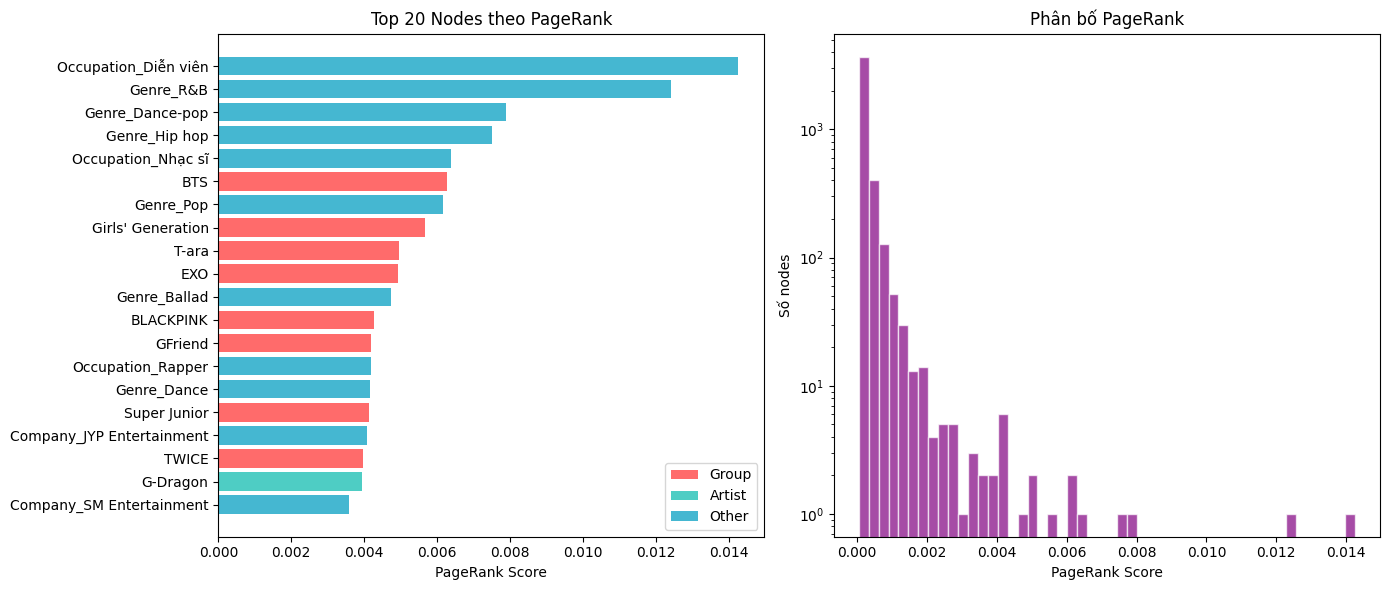

✓ Đã lưu biểu đồ vào pagerank_analysis.png


📊 PAGERANK TRUNG BÌNH THEO LABEL:
--------------------------------------------------


,Label,Count,Avg PageRank,Max PageRank
0,Group,261,0.000819,0.006266
7,Occupation,60,0.000753,0.014255
5,Genre,175,0.000424,0.012407
6,Instrument,32,0.000316,0.002765
1,Artist,1165,0.000277,0.003937
4,Company,323,0.000231,0.004067
2,Album,771,0.000112,0.000662
3,Song,1586,0.000109,0.000713



🏆 TOP NODE THEO TỪNG LABEL:
----------------------------------------------------------------------

📌 Top 5 Group:
   1. BTS (PageRank: 0.006266)
   2. Girls' Generation (PageRank: 0.005675)
   3. T-ara (PageRank: 0.004950)
   4. EXO (PageRank: 0.004916)
   5. BLACKPINK (PageRank: 0.004268)

📌 Top 5 Artist:
   1. G-Dragon (PageRank: 0.003937)
   2. Taeyeon (PageRank: 0.003310)
   3. Mnet (PageRank: 0.002662)
   4. IU (ca sĩ) (PageRank: 0.002582)
   5. Yoo Young-jin (PageRank: 0.002560)

📌 Top 5 Song:
   1. Girls (PageRank: 0.000713)
   2. Confession (PageRank: 0.000578)
   3. BEcause (PageRank: 0.000560)
   4. Love Me (PageRank: 0.000544)
   5. The Revolution Will Not Be Televised (PageRank: 0.000515)

📌 Top 5 Album:
   1. I Got a Boy (PageRank: 0.000662)
   2. Alive (PageRank: 0.000635)
   3. Born Pink (PageRank: 0.000570)
   4. Absolute First Album (PageRank: 0.000558)
   5. The Secret Code (PageRank: 0.000524)

📌 Top 5 Company:
   1. Company_JYP Entertainment (PageRank: 0.004067)
 

3. PHÁT HIỆN CỘNG ĐỒNG (COMMUNITY DETECTION)

🔍 Sử dụng thuật toán Louvain...
✓ Phát hiện được 1899 cộng đồng (phương pháp: Louvain)
✓ Modularity: 0.6129
   → Modularity > 0.3: Cấu trúc cộng đồng RÕ RÀNG

📊 THỐNG KÊ:
   - Nhỏ nhất: 1 nodes
   - Lớn nhất: 376 nodes
   - Trung bình: 2.3 nodes


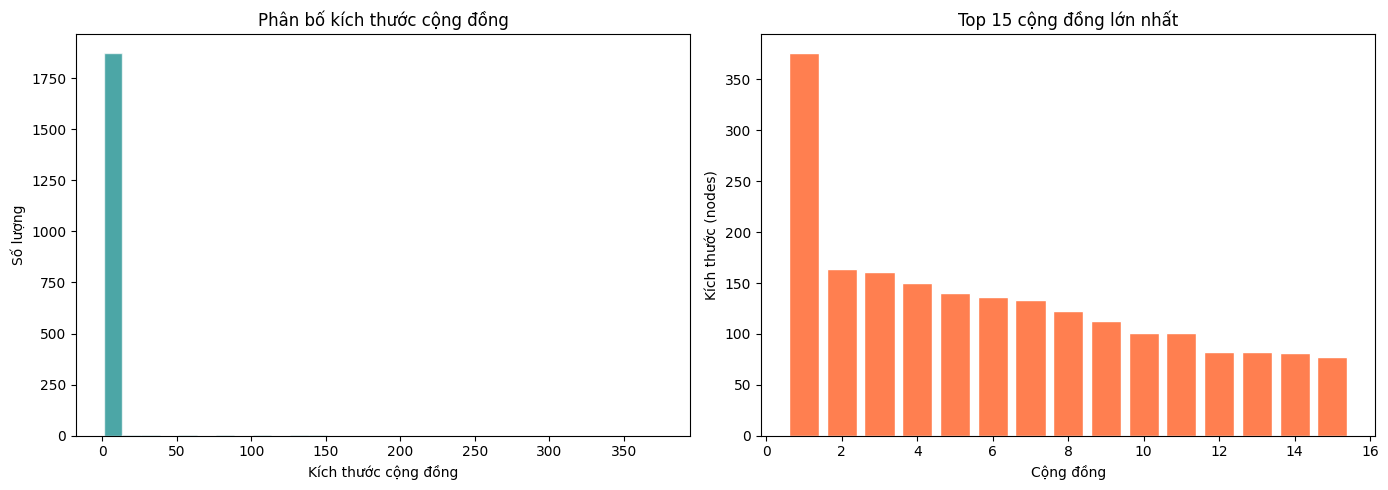

✓ Đã lưu biểu đồ vào community_analysis.png


📊 CHI TIẾT TOP 10 CỘNG ĐỒNG LỚN NHẤT:

🔹 Cộng đồng 1: 376 nodes
   Label chủ đạo: Artist (210 nodes, 55.9%)
   Node quan trọng nhất: Occupation_Diễn viên
   Nodes mẫu: Im Si-wan, Dana (ca sĩ Hàn Quốc), Park Ye-eun...

🔹 Cộng đồng 2: 164 nodes
   Label chủ đạo: Song (71 nodes, 43.3%)
   Node quan trọng nhất: Girls' Generation
   Nodes mẫu: Turbulence, Very Merry Xmas, I (EP của Taeyeon)...

🔹 Cộng đồng 3: 161 nodes
   Label chủ đạo: Artist (80 nodes, 49.7%)
   Node quan trọng nhất: Genre_Dance-pop
   Nodes mẫu: Hani (ca sĩ), Han Seung-woo, Zoa...

🔹 Cộng đồng 4: 150 nodes
   Label chủ đạo: Artist (53 nodes, 35.3%)
   Node quan trọng nhất: Genre_J-pop
   Nodes mẫu: Company_Gold Typhoon, Chanmi, AOA...

🔹 Cộng đồng 5: 140 nodes
   Label chủ đạo: Artist (44 nodes, 31.4%)
   Node quan trọng nhất: EXO
   Nodes mẫu: Sakuya, Kris, Instrument_Violin...

🔹 Cộng đồng 6: 136 nodes
   Label chủ đạo: Song (49 nodes, 36.0%)
   Node quan trọng nhất: BLACKPINK
   Nodes mẫu: Mire, Bet You Wanna, Ice Cre

,Community,Size,Dominant Label,Dominant %,Top Node
0,1,376,Artist,55.9%,Occupation_Diễn viên
1,2,164,Song,43.3%,Girls' Generation
2,3,161,Artist,49.7%,Genre_Dance-pop
3,4,150,Artist,35.3%,Genre_J-pop
4,5,140,Artist,31.4%,EXO
5,6,136,Song,36.0%,BLACKPINK
6,7,133,Song,43.6%,Super Junior
7,8,123,Song,52.8%,BTS
8,9,113,Song,37.2%,T-ara
9,10,101,Song,43.6%,TWICE


📋 KẾT LUẬN VỀ CẤU TRÚC CỘNG ĐỒNG:

1. Mạng K-pop có 1899 cộng đồng được phát hiện

2. Modularity = 0.6129 (CAO)
   → Cấu trúc cộng đồng rõ ràng, các nodes trong cùng cộng đồng liên kết chặt chẽ

3. Cộng đồng lớn nhất có 376 nodes (8.6% mạng)

💡 DIỄN GIẢI:
   Các cộng đồng có thể đại diện cho:
   • Nghệ sĩ cùng công ty (SM, YG, JYP, HYBE...)
   • Thế hệ idol (1st, 2nd, 3rd, 4th generation)
   • Các nhóm nhạc và thành viên của họ
   • Mối quan hệ hợp tác, collab, featuring


📊 TỔNG KẾT PHÂN TÍCH MẠNG XÃ HỘI K-POP

📌 THÔNG TIN MẠNG:
   - Số nodes: 4373
   - Số edges: 5419
   - Average Degree: 4.36

1️⃣  THẾ GIỚI NHỎ (SMALL WORLD):
   - Average Path Length: 4.39
   - Clustering Coefficient: 0.0560
   - Diameter: 12
   - Kết luận: ✓ Mạng CÓ tính chất Small World

2️⃣  PAGERANK - TOP 5 NODES QUAN TRỌNG NHẤT:
   1. Occupation_Diễn viên (Occupation) - PageRank: 0.014255
   2. Genre_R&B (Genre) - PageRank: 0.012407
   3. Genre_Dance-pop (Genre) - PageRank: 0.007878
   4. Genre_Hip hop (Genre) - PageRank: 0.007499
   5. Occupation_Nhạc sĩ (Occupation) - PageRank: 0.006380

3️⃣  CỘNG ĐỒNG:
   - Số cộng đồng: 1899
   - Modularity: 0.6129
   - Cộng đồng lớn nhất: 376 nodes

✓ HOÀN TẤT PHÂN TÍCH


✓ Đã lưu kết quả vào network_analysis_results.json


# Phân tích và trực quan hóa mạng nghệ sĩ Hàn Quốc

Notebook này tải file JSON kết quả (`korean_artists_graph_bfs.json`), tổng hợp thống kê và vẽ một số biểu đồ/đồ thị mạng cơ bản.

Yêu cầu môi trường: pandas, matplotlib, networkx, plotly (tùy chọn).


In [18]:
# Cài đặt bổ sung (nếu cần) - có thể bỏ qua nếu đã có
# !pip install pandas matplotlib networkx plotly

import json
from collections import Counter
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

try:
    import networkx as nx
except ImportError:
    nx = None

DATA_PATH = Path('merged_kpop_data.json')
assert DATA_PATH.exists(), f"Không tìm thấy file {DATA_PATH.resolve()}"

with open(DATA_PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)

nodes = data.get('nodes', {})
edges = data.get('edges', [])
stats = data.get('statistics', {})

print(f"Nodes: {len(nodes):,} | Edges: {len(edges):,}")



Nodes: 4,373 | Edges: 5,830


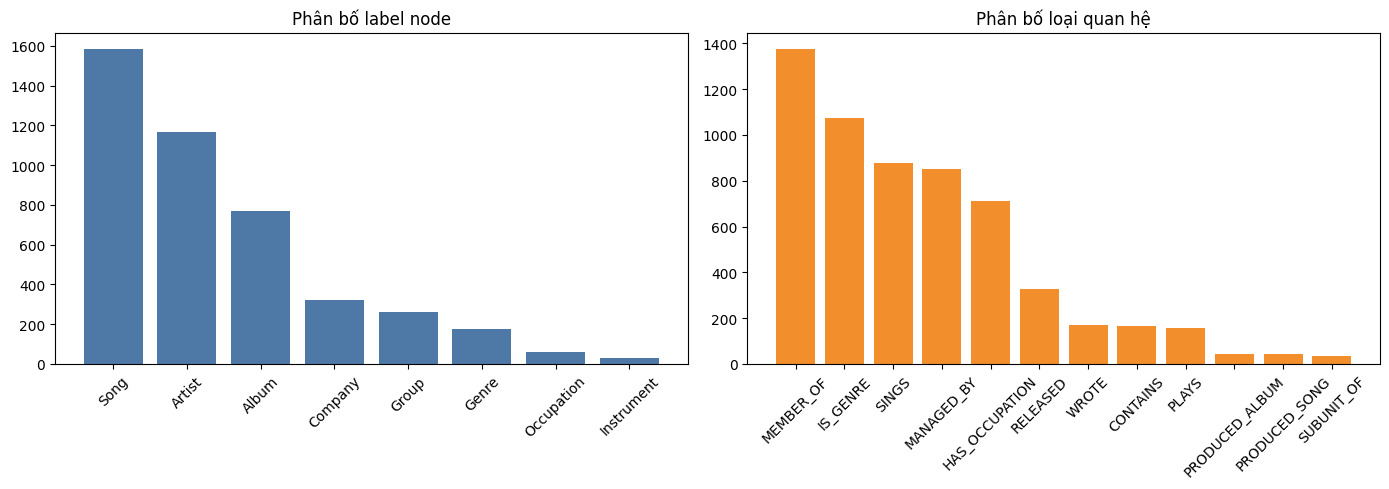

(     label  count
 3     Song   1586
 1   Artist   1165
 2    Album    771
 4  Company    323
 0    Group    261,
              type  count
 0       MEMBER_OF   1377
 9        IS_GENRE   1072
 1           SINGS    879
 8      MANAGED_BY    852
 7  HAS_OCCUPATION    711)

In [19]:
# Thống kê theo label và loại cạnh
label_counts = Counter([node.get('label', 'Unknown') for node in nodes.values()])
edge_type_counts = Counter([e.get('type', 'RELATED_TO') for e in edges])

label_df = pd.DataFrame(label_counts.items(), columns=['label', 'count']).sort_values('count', ascending=False)
edge_df = pd.DataFrame(edge_type_counts.items(), columns=['type', 'count']).sort_values('count', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].bar(label_df['label'], label_df['count'], color='#4E79A7')
axes[0].set_title('Phân bố label node')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(edge_df['type'], edge_df['count'], color='#F28E2B')
axes[1].set_title('Phân bố loại quan hệ')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

label_df.head(), edge_df.head()


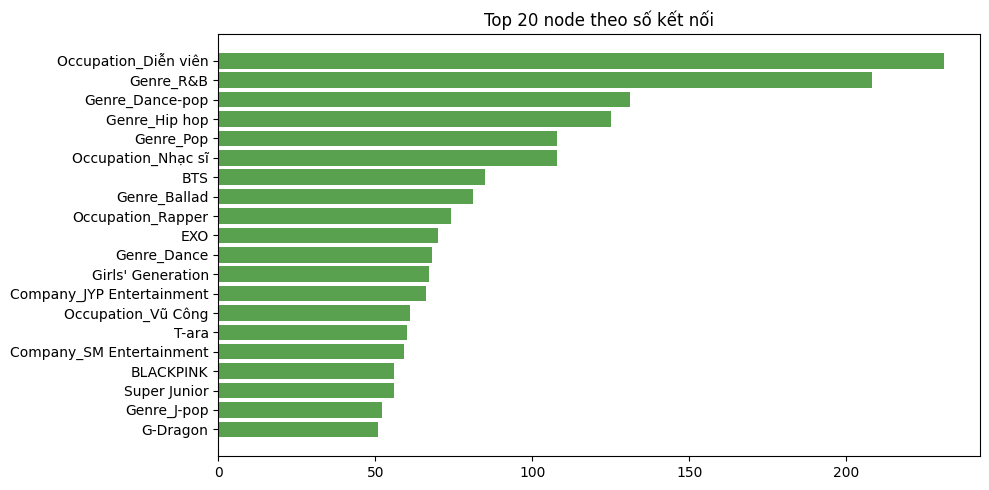

In [20]:
# Top node theo độ kết nối (nếu networkx khả dụng)
if nx is not None:
    G = nx.Graph()
    for key, n in nodes.items():
        G.add_node(key, **n)
    for e in edges:
        s, t = e.get('source'), e.get('target')
        if s in nodes and t in nodes:
            G.add_edge(s, t, **e)

    deg = dict(G.degree())
    top_deg = sorted(deg.items(), key=lambda x: x[1], reverse=True)[:20]
    top_df = pd.DataFrame(top_deg, columns=['node', 'degree'])
    top_df['label'] = top_df['node'].map(lambda k: nodes[k].get('label'))

    plt.figure(figsize=(10,5))
    plt.barh(top_df['node'][::-1], top_df['degree'][::-1], color='#59A14F')
    plt.title('Top 20 node theo số kết nối')
    plt.tight_layout()
    plt.show()

    top_df.head(10)
else:
    print('networkx chưa cài, bỏ qua bước tính độ.')


In [21]:
# Top 5 node có nhiều kết nối nhất cho mỗi loại label
import pandas as pd

if nx is not None:
    # Bảo đảm có graph G
    if 'G' not in globals():
        G = nx.Graph()
        for key in nodes:
            G.add_node(key)
        for e in edges:
            s, t = e.get('source'), e.get('target')
            if s in nodes and t in nodes:
                G.add_edge(s, t)

    degree_map = dict(G.degree())
    label_map = {k: v.get('label') for k, v in nodes.items()}
    title_map = {k: v.get('title', k) for k, v in nodes.items()}

    deg_df = pd.DataFrame([
        {'id': nid, 'title': title_map.get(nid, nid), 'label': label_map.get(nid, 'Unknown'), 'degree': deg}
        for nid, deg in degree_map.items()
    ])

    top5_by_label = (
        deg_df.sort_values(['label', 'degree'], ascending=[True, False])
              .groupby('label', as_index=False)
              .head(5)
              .reset_index(drop=True)
    )

    display(top5_by_label)
else:
    print('networkx chưa cài, bỏ qua bước này')


,id,title,label,degree
0,Born Pink,Born Pink,Album,8
1,I Got a Boy,I Got a Boy,Album,8
2,The Album (album của Blackpink),The Album (album của Blackpink),Album,7
3,Made (album của Big Bang),Made (album của Big Bang),Album,7
4,Absolute First Album,Absolute First Album,Album,6
5,G-Dragon,G-Dragon,Artist,51
6,Yoo Young-jin,Yoo Young-jin,Artist,38
7,Taeyeon,Taeyeon,Artist,35
8,Kenzie,Kenzie,Artist,35
9,Mnet,Mnet,Artist,33


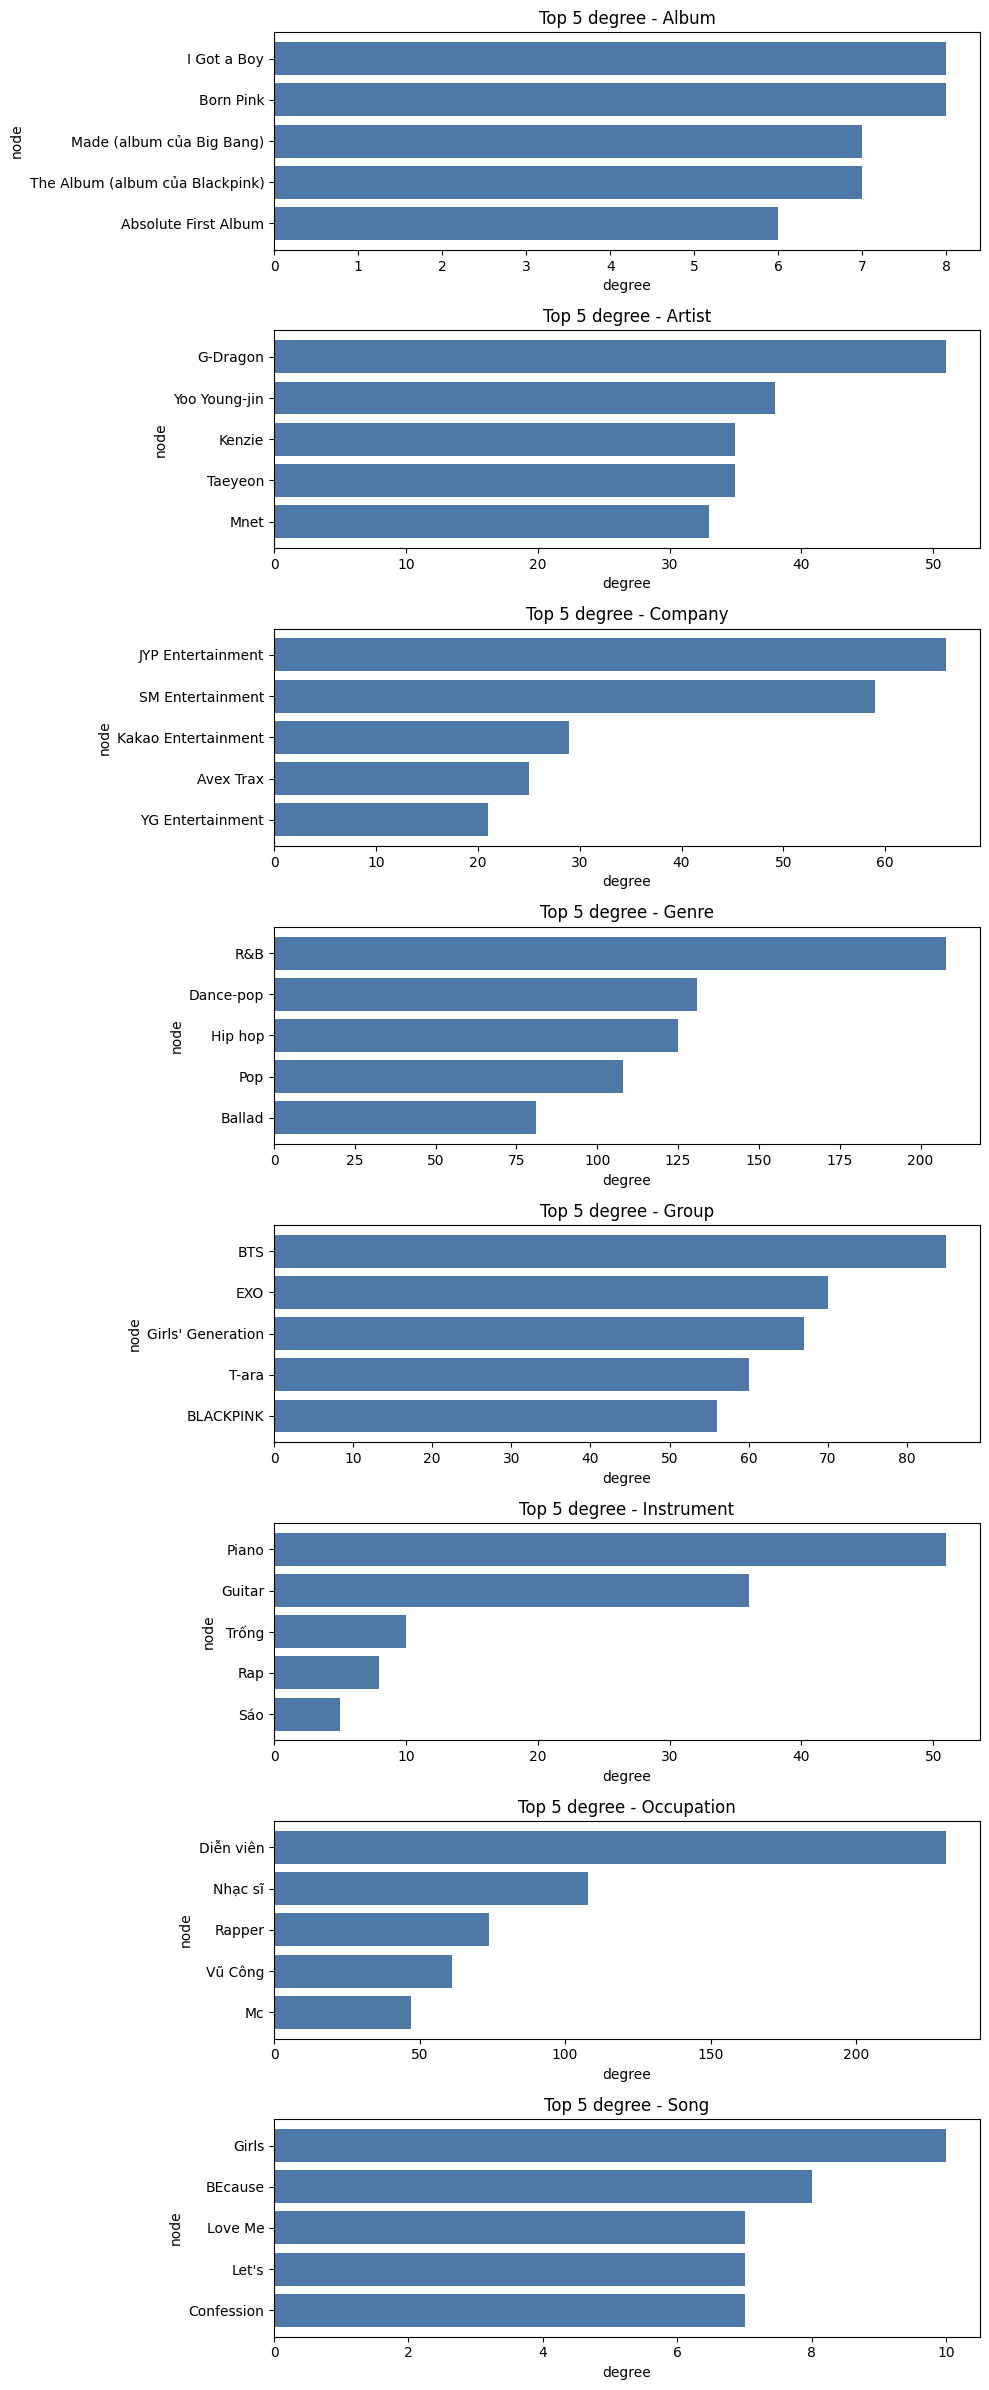

In [22]:
# Biểu đồ Top 5 node theo degree cho mỗi label
if 'top5_by_label' in globals() and not top5_by_label.empty:
    labels = sorted(top5_by_label['label'].unique())
    n = len(labels)
    fig, axes = plt.subplots(n, 1, figsize=(10, 3*n), squeeze=False)
    for i, lbl in enumerate(labels):
        sub = top5_by_label[top5_by_label['label'] == lbl].sort_values('degree')
        axes[i,0].barh(sub['title'], sub['degree'], color='#4E79A7')
        axes[i,0].set_title(f'Top 5 degree - {lbl}')
        axes[i,0].set_xlabel('degree')
        axes[i,0].set_ylabel('node')
    plt.tight_layout(); plt.show()
else:
    print('Chưa có bảng top5_by_label — chạy cell tính top 5 trước.')
